In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "TwJul97.5"
station_dv = "TwJul2.5 (degC)"
station_path = "data/station_inputs/julTwb97.5p_allstations_v3_for_maps.csv"
input_model_path = (
    "data/model_inputs/twb_CanRCM4-LE_ens35_1951-2016_1hr_jul97.5p_ensmean.nc"
)
medians = {"value": 21, "action": "add"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = True


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,TwJul2.5 (degC),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,549,1019,25.1,-4.655459,10.812370,41.8333,-82.4667,195,SOUTHEAST SHOAL (AUT),ON,28.611820,0.999757
1,552,1011,24.9,-4.517790,10.457750,42.0333,-82.9000,191,HARROW CDA AUTO,ON,28.887081,0.998176
2,552,1017,26.0,-4.549355,10.752628,41.9486,-82.5189,177,POINT PELEE CS,ON,28.664274,1.002599


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

282.840625

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/527 [00:00<?, ?it/s]

  0%|          | 2/527 [00:00<02:45,  3.17it/s]

  1%|          | 3/527 [00:01<03:21,  2.60it/s]

  1%|          | 4/527 [00:01<03:46,  2.31it/s]

  1%|          | 5/527 [00:02<04:11,  2.08it/s]

  1%|          | 6/527 [00:02<04:27,  1.95it/s]

  1%|▏         | 7/527 [00:03<04:36,  1.88it/s]

  2%|▏         | 8/527 [00:04<04:38,  1.86it/s]

  2%|▏         | 9/527 [00:04<04:44,  1.82it/s]

  2%|▏         | 10/527 [00:05<04:47,  1.80it/s]

  2%|▏         | 11/527 [00:05<04:56,  1.74it/s]

  2%|▏         | 12/527 [00:06<04:52,  1.76it/s]

  2%|▏         | 13/527 [00:06<04:48,  1.78it/s]

  3%|▎         | 14/527 [00:07<04:45,  1.79it/s]

  3%|▎         | 15/527 [00:07<04:44,  1.80it/s]

  3%|▎         | 16/527 [00:08<04:39,  1.83it/s]

  3%|▎         | 17/527 [00:09<04:41,  1.81it/s]

  3%|▎         | 18/527 [00:09<04:41,  1.81it/s]

  4%|▎         | 19/527 [00:10<04:40,  1.81it/s]

  4%|▍         | 20/527 [00:10<04:34,  1.85it/s]

  4%|▍         | 21/527 [00:11<04:31,  1.87it/s]

  4%|▍         | 22/527 [00:11<04:32,  1.85it/s]

  4%|▍         | 23/527 [00:12<04:28,  1.87it/s]

  5%|▍         | 24/527 [00:12<04:27,  1.88it/s]

  5%|▍         | 25/527 [00:13<04:29,  1.86it/s]

  5%|▍         | 26/527 [00:13<04:30,  1.85it/s]

  5%|▌         | 27/527 [00:14<04:32,  1.83it/s]

  5%|▌         | 28/527 [00:14<04:28,  1.86it/s]

  6%|▌         | 29/527 [00:15<04:24,  1.88it/s]

  6%|▌         | 30/527 [00:16<04:25,  1.88it/s]

  6%|▌         | 31/527 [00:16<04:26,  1.86it/s]

  6%|▌         | 32/527 [00:17<04:25,  1.86it/s]

  6%|▋         | 33/527 [00:17<04:24,  1.87it/s]

  6%|▋         | 34/527 [00:18<04:22,  1.88it/s]

  7%|▋         | 35/527 [00:18<04:25,  1.85it/s]

  7%|▋         | 36/527 [00:19<04:29,  1.82it/s]

  7%|▋         | 37/527 [00:19<04:27,  1.83it/s]

  7%|▋         | 38/527 [00:20<04:22,  1.86it/s]

  7%|▋         | 39/527 [00:20<04:27,  1.82it/s]

  8%|▊         | 40/527 [00:21<04:26,  1.83it/s]

  8%|▊         | 41/527 [00:22<04:26,  1.83it/s]

  8%|▊         | 42/527 [00:22<04:30,  1.79it/s]

  8%|▊         | 43/527 [00:23<04:32,  1.78it/s]

  8%|▊         | 44/527 [00:23<04:33,  1.76it/s]

  9%|▊         | 45/527 [00:24<04:33,  1.77it/s]

  9%|▊         | 46/527 [00:24<04:35,  1.74it/s]

  9%|▉         | 47/527 [00:25<04:41,  1.71it/s]

  9%|▉         | 48/527 [00:26<04:41,  1.70it/s]

  9%|▉         | 49/527 [00:26<04:35,  1.73it/s]

  9%|▉         | 50/527 [00:27<04:42,  1.69it/s]

 10%|▉         | 51/527 [00:27<04:37,  1.72it/s]

 10%|▉         | 52/527 [00:28<04:41,  1.69it/s]

 10%|█         | 53/527 [00:29<04:39,  1.70it/s]

 10%|█         | 54/527 [00:29<04:39,  1.69it/s]

 10%|█         | 55/527 [00:30<04:35,  1.71it/s]

 11%|█         | 56/527 [00:30<04:30,  1.74it/s]

 11%|█         | 57/527 [00:31<04:31,  1.73it/s]

 11%|█         | 58/527 [00:32<04:47,  1.63it/s]

 11%|█         | 59/527 [00:32<04:53,  1.60it/s]

 11%|█▏        | 60/527 [00:33<04:44,  1.64it/s]

 12%|█▏        | 61/527 [00:33<04:38,  1.67it/s]

 12%|█▏        | 62/527 [00:34<04:30,  1.72it/s]

 12%|█▏        | 63/527 [00:34<04:30,  1.71it/s]

 12%|█▏        | 64/527 [00:35<04:31,  1.71it/s]

 12%|█▏        | 65/527 [00:36<04:24,  1.75it/s]

 13%|█▎        | 66/527 [00:36<04:34,  1.68it/s]

 13%|█▎        | 67/527 [00:37<04:40,  1.64it/s]

 13%|█▎        | 68/527 [00:38<04:48,  1.59it/s]

 13%|█▎        | 69/527 [00:38<04:42,  1.62it/s]

 13%|█▎        | 70/527 [00:39<04:39,  1.63it/s]

 13%|█▎        | 71/527 [00:39<04:32,  1.68it/s]

 14%|█▎        | 72/527 [00:40<04:23,  1.73it/s]

 14%|█▍        | 73/527 [00:40<04:26,  1.71it/s]

 14%|█▍        | 74/527 [00:41<04:25,  1.71it/s]

 14%|█▍        | 75/527 [00:42<04:18,  1.75it/s]

 14%|█▍        | 76/527 [00:42<04:21,  1.72it/s]

 15%|█▍        | 77/527 [00:43<04:16,  1.76it/s]

 15%|█▍        | 78/527 [00:43<04:14,  1.77it/s]

 15%|█▍        | 79/527 [00:44<04:13,  1.76it/s]

 15%|█▌        | 80/527 [00:44<04:11,  1.78it/s]

 15%|█▌        | 81/527 [00:45<04:39,  1.59it/s]

 16%|█▌        | 82/527 [00:46<04:31,  1.64it/s]

 16%|█▌        | 83/527 [00:46<04:33,  1.62it/s]

 16%|█▌        | 84/527 [00:47<04:28,  1.65it/s]

 16%|█▌        | 85/527 [00:48<04:26,  1.66it/s]

 16%|█▋        | 86/527 [00:48<04:23,  1.68it/s]

 17%|█▋        | 87/527 [00:49<04:31,  1.62it/s]

 17%|█▋        | 88/527 [00:49<04:24,  1.66it/s]

 17%|█▋        | 89/527 [00:50<04:17,  1.70it/s]

 17%|█▋        | 90/527 [00:51<04:13,  1.72it/s]

 17%|█▋        | 91/527 [00:51<04:15,  1.71it/s]

 17%|█▋        | 92/527 [00:52<04:12,  1.72it/s]

 18%|█▊        | 93/527 [00:52<04:16,  1.69it/s]

 18%|█▊        | 94/527 [00:53<04:16,  1.69it/s]

 18%|█▊        | 95/527 [00:53<04:14,  1.70it/s]

 18%|█▊        | 96/527 [00:54<04:15,  1.69it/s]

 18%|█▊        | 97/527 [00:55<04:38,  1.54it/s]

 19%|█▊        | 98/527 [00:55<04:27,  1.61it/s]

 19%|█▉        | 99/527 [00:56<04:20,  1.64it/s]

 19%|█▉        | 100/527 [00:57<04:18,  1.65it/s]

 19%|█▉        | 101/527 [00:57<04:14,  1.67it/s]

 19%|█▉        | 102/527 [00:58<04:16,  1.65it/s]

 20%|█▉        | 103/527 [00:58<04:16,  1.65it/s]

 20%|█▉        | 104/527 [00:59<04:14,  1.66it/s]

 20%|█▉        | 105/527 [01:00<04:06,  1.71it/s]

 20%|██        | 106/527 [01:00<04:02,  1.74it/s]

 20%|██        | 107/527 [01:01<04:00,  1.75it/s]

 20%|██        | 108/527 [01:01<03:58,  1.76it/s]

 21%|██        | 109/527 [01:02<03:53,  1.79it/s]

 21%|██        | 110/527 [01:02<03:47,  1.84it/s]

 21%|██        | 111/527 [01:03<03:44,  1.85it/s]

 21%|██▏       | 112/527 [01:03<03:42,  1.87it/s]

 21%|██▏       | 113/527 [01:04<03:38,  1.89it/s]

 22%|██▏       | 114/527 [01:04<03:40,  1.87it/s]

 22%|██▏       | 115/527 [01:05<03:37,  1.89it/s]

 22%|██▏       | 116/527 [01:05<03:40,  1.87it/s]

 22%|██▏       | 117/527 [01:06<03:40,  1.86it/s]

 22%|██▏       | 118/527 [01:07<03:39,  1.86it/s]

 23%|██▎       | 119/527 [01:07<03:39,  1.86it/s]

 23%|██▎       | 120/527 [01:08<03:42,  1.83it/s]

 23%|██▎       | 121/527 [01:08<03:43,  1.82it/s]

 23%|██▎       | 122/527 [01:09<03:46,  1.79it/s]

 23%|██▎       | 123/527 [01:09<03:45,  1.79it/s]

 24%|██▎       | 124/527 [01:10<03:46,  1.78it/s]

 24%|██▎       | 125/527 [01:10<03:46,  1.78it/s]

 24%|██▍       | 126/527 [01:11<03:47,  1.77it/s]

 24%|██▍       | 127/527 [01:12<03:38,  1.83it/s]

 24%|██▍       | 128/527 [01:12<03:35,  1.86it/s]

 24%|██▍       | 129/527 [01:13<03:33,  1.86it/s]

 25%|██▍       | 130/527 [01:13<03:29,  1.89it/s]

 25%|██▍       | 131/527 [01:14<03:27,  1.91it/s]

 25%|██▌       | 132/527 [01:14<03:27,  1.90it/s]

 25%|██▌       | 133/527 [01:15<03:28,  1.89it/s]

 25%|██▌       | 134/527 [01:15<03:27,  1.90it/s]

 26%|██▌       | 135/527 [01:16<03:28,  1.88it/s]

 26%|██▌       | 136/527 [01:16<03:27,  1.88it/s]

 26%|██▌       | 137/527 [01:17<03:27,  1.88it/s]

 26%|██▌       | 138/527 [01:17<03:27,  1.87it/s]

 26%|██▋       | 139/527 [01:18<03:37,  1.78it/s]

 27%|██▋       | 140/527 [01:19<04:00,  1.61it/s]

 27%|██▋       | 141/527 [01:19<03:50,  1.68it/s]

 27%|██▋       | 142/527 [01:20<03:50,  1.67it/s]

 27%|██▋       | 143/527 [01:20<03:36,  1.77it/s]

 27%|██▋       | 144/527 [01:21<03:28,  1.84it/s]

 28%|██▊       | 145/527 [01:22<03:39,  1.74it/s]

 28%|██▊       | 146/527 [01:22<03:33,  1.79it/s]

 28%|██▊       | 147/527 [01:23<03:25,  1.85it/s]

 28%|██▊       | 148/527 [01:23<03:26,  1.84it/s]

 28%|██▊       | 149/527 [01:24<03:33,  1.77it/s]

 28%|██▊       | 150/527 [01:24<03:29,  1.80it/s]

 29%|██▊       | 151/527 [01:25<03:29,  1.79it/s]

 29%|██▉       | 152/527 [01:25<03:30,  1.78it/s]

 29%|██▉       | 153/527 [01:26<03:36,  1.73it/s]

 29%|██▉       | 154/527 [01:27<03:37,  1.72it/s]

 29%|██▉       | 155/527 [01:27<03:35,  1.73it/s]

 30%|██▉       | 156/527 [01:28<03:35,  1.72it/s]

 30%|██▉       | 157/527 [01:28<03:29,  1.77it/s]

 30%|██▉       | 158/527 [01:29<03:28,  1.77it/s]

 30%|███       | 159/527 [01:29<03:25,  1.79it/s]

 30%|███       | 160/527 [01:30<03:25,  1.78it/s]

 31%|███       | 161/527 [01:30<03:26,  1.78it/s]

 31%|███       | 162/527 [01:31<03:22,  1.80it/s]

 31%|███       | 163/527 [01:32<03:34,  1.69it/s]

 31%|███       | 164/527 [01:32<03:26,  1.76it/s]

 31%|███▏      | 165/527 [01:33<03:24,  1.77it/s]

 31%|███▏      | 166/527 [01:33<03:21,  1.79it/s]

 32%|███▏      | 167/527 [01:34<03:23,  1.77it/s]

 32%|███▏      | 168/527 [01:34<03:19,  1.80it/s]

 32%|███▏      | 169/527 [01:35<03:18,  1.80it/s]

 32%|███▏      | 170/527 [01:36<03:24,  1.75it/s]

 32%|███▏      | 171/527 [01:36<03:18,  1.79it/s]

 33%|███▎      | 172/527 [01:37<03:19,  1.78it/s]

 33%|███▎      | 173/527 [01:37<03:18,  1.79it/s]

 33%|███▎      | 174/527 [01:38<03:18,  1.78it/s]

 33%|███▎      | 175/527 [01:38<03:12,  1.83it/s]

 33%|███▎      | 176/527 [01:39<03:09,  1.85it/s]

 34%|███▎      | 177/527 [01:39<03:13,  1.81it/s]

 34%|███▍      | 178/527 [01:40<03:14,  1.79it/s]

 34%|███▍      | 179/527 [01:41<03:14,  1.79it/s]

 34%|███▍      | 180/527 [01:41<03:15,  1.77it/s]

 34%|███▍      | 181/527 [01:42<03:14,  1.78it/s]

 35%|███▍      | 182/527 [01:42<03:09,  1.82it/s]

 35%|███▍      | 183/527 [01:43<03:06,  1.84it/s]

 35%|███▍      | 184/527 [01:43<03:12,  1.78it/s]

 35%|███▌      | 185/527 [01:44<03:07,  1.82it/s]

 35%|███▌      | 186/527 [01:44<03:08,  1.81it/s]

 35%|███▌      | 187/527 [01:45<03:02,  1.86it/s]

 36%|███▌      | 188/527 [01:45<03:03,  1.85it/s]

 36%|███▌      | 189/527 [01:46<03:03,  1.84it/s]

 36%|███▌      | 190/527 [01:47<03:01,  1.86it/s]

 36%|███▌      | 191/527 [01:47<03:02,  1.84it/s]

 36%|███▋      | 192/527 [01:48<03:00,  1.85it/s]

 37%|███▋      | 193/527 [01:48<03:04,  1.81it/s]

 37%|███▋      | 194/527 [01:49<03:01,  1.84it/s]

 37%|███▋      | 195/527 [01:49<02:57,  1.87it/s]

 37%|███▋      | 196/527 [01:50<02:55,  1.89it/s]

 37%|███▋      | 197/527 [01:50<02:55,  1.88it/s]

 38%|███▊      | 198/527 [01:51<02:55,  1.88it/s]

 38%|███▊      | 199/527 [01:51<02:55,  1.87it/s]

 38%|███▊      | 200/527 [01:52<02:56,  1.85it/s]

 38%|███▊      | 201/527 [01:53<03:01,  1.80it/s]

 38%|███▊      | 202/527 [01:53<02:59,  1.81it/s]

 39%|███▊      | 203/527 [01:54<02:56,  1.84it/s]

 39%|███▊      | 204/527 [01:54<02:57,  1.82it/s]

 39%|███▉      | 205/527 [01:55<02:56,  1.83it/s]

 39%|███▉      | 206/527 [01:55<02:54,  1.84it/s]

 39%|███▉      | 207/527 [01:56<02:58,  1.80it/s]

 39%|███▉      | 208/527 [01:56<02:54,  1.83it/s]

 40%|███▉      | 209/527 [01:57<02:54,  1.82it/s]

 40%|███▉      | 210/527 [01:57<02:53,  1.82it/s]

 40%|████      | 211/527 [01:58<02:52,  1.84it/s]

 40%|████      | 212/527 [01:59<02:50,  1.85it/s]

 40%|████      | 213/527 [01:59<02:50,  1.84it/s]

 41%|████      | 214/527 [02:00<02:51,  1.82it/s]

 41%|████      | 215/527 [02:00<02:47,  1.87it/s]

 41%|████      | 216/527 [02:01<02:55,  1.77it/s]

 41%|████      | 217/527 [02:01<02:52,  1.80it/s]

 41%|████▏     | 218/527 [02:02<02:49,  1.82it/s]

 42%|████▏     | 219/527 [02:02<02:49,  1.82it/s]

 42%|████▏     | 220/527 [02:03<02:48,  1.82it/s]

 42%|████▏     | 221/527 [02:03<02:46,  1.83it/s]

 42%|████▏     | 222/527 [02:04<02:46,  1.83it/s]

 42%|████▏     | 223/527 [02:05<02:45,  1.83it/s]

 43%|████▎     | 224/527 [02:05<02:47,  1.81it/s]

 43%|████▎     | 225/527 [02:06<02:46,  1.81it/s]

 43%|████▎     | 226/527 [02:06<02:45,  1.82it/s]

 43%|████▎     | 227/527 [02:07<02:46,  1.81it/s]

 43%|████▎     | 228/527 [02:07<02:47,  1.78it/s]

 43%|████▎     | 229/527 [02:08<02:46,  1.79it/s]

 44%|████▎     | 230/527 [02:08<02:44,  1.81it/s]

 44%|████▍     | 231/527 [02:09<02:48,  1.76it/s]

 44%|████▍     | 232/527 [02:10<02:45,  1.78it/s]

 44%|████▍     | 233/527 [02:10<02:46,  1.77it/s]

 44%|████▍     | 234/527 [02:11<02:42,  1.80it/s]

 45%|████▍     | 235/527 [02:11<02:39,  1.83it/s]

 45%|████▍     | 236/527 [02:12<02:48,  1.72it/s]

 45%|████▍     | 237/527 [02:12<02:48,  1.73it/s]

 45%|████▌     | 238/527 [02:13<02:51,  1.68it/s]

 45%|████▌     | 239/527 [02:14<02:50,  1.69it/s]

 46%|████▌     | 240/527 [02:14<02:44,  1.75it/s]

 46%|████▌     | 241/527 [02:15<02:40,  1.78it/s]

 46%|████▌     | 242/527 [02:15<02:39,  1.78it/s]

 46%|████▌     | 243/527 [02:16<02:40,  1.77it/s]

 46%|████▋     | 244/527 [02:16<02:39,  1.77it/s]

 46%|████▋     | 245/527 [02:17<02:37,  1.79it/s]

 47%|████▋     | 246/527 [02:18<02:36,  1.79it/s]

 47%|████▋     | 247/527 [02:18<02:42,  1.72it/s]

 47%|████▋     | 248/527 [02:19<02:45,  1.69it/s]

 47%|████▋     | 249/527 [02:19<02:37,  1.76it/s]

 47%|████▋     | 250/527 [02:20<02:40,  1.73it/s]

 48%|████▊     | 251/527 [02:21<02:40,  1.72it/s]

 48%|████▊     | 252/527 [02:21<02:41,  1.70it/s]

 48%|████▊     | 253/527 [02:22<02:41,  1.69it/s]

 48%|████▊     | 254/527 [02:22<02:47,  1.63it/s]

 48%|████▊     | 255/527 [02:23<02:41,  1.68it/s]

 49%|████▊     | 256/527 [02:24<02:41,  1.68it/s]

 49%|████▉     | 257/527 [02:24<02:40,  1.68it/s]

 49%|████▉     | 258/527 [02:25<02:37,  1.71it/s]

 49%|████▉     | 259/527 [02:25<02:35,  1.73it/s]

 49%|████▉     | 260/527 [02:26<02:32,  1.75it/s]

 50%|████▉     | 261/527 [02:26<02:31,  1.75it/s]

 50%|████▉     | 262/527 [02:27<02:32,  1.74it/s]

 50%|████▉     | 263/527 [02:27<02:28,  1.78it/s]

 50%|█████     | 264/527 [02:28<02:26,  1.79it/s]

 50%|█████     | 265/527 [02:29<02:26,  1.79it/s]

 50%|█████     | 266/527 [02:29<02:24,  1.81it/s]

 51%|█████     | 267/527 [02:30<02:25,  1.78it/s]

 51%|█████     | 268/527 [02:30<02:25,  1.79it/s]

 51%|█████     | 269/527 [02:31<02:27,  1.75it/s]

 51%|█████     | 270/527 [02:31<02:26,  1.75it/s]

 51%|█████▏    | 271/527 [02:32<02:26,  1.75it/s]

 52%|█████▏    | 272/527 [02:33<02:24,  1.76it/s]

 52%|█████▏    | 273/527 [02:33<02:24,  1.76it/s]

 52%|█████▏    | 274/527 [02:34<02:22,  1.77it/s]

 52%|█████▏    | 275/527 [02:34<02:20,  1.79it/s]

 52%|█████▏    | 276/527 [02:35<02:18,  1.81it/s]

 53%|█████▎    | 277/527 [02:35<02:19,  1.79it/s]

 53%|█████▎    | 278/527 [02:36<02:21,  1.76it/s]

 53%|█████▎    | 279/527 [02:37<02:23,  1.72it/s]

 53%|█████▎    | 280/527 [02:37<02:28,  1.66it/s]

 53%|█████▎    | 281/527 [02:38<02:33,  1.60it/s]

 54%|█████▎    | 282/527 [02:38<02:28,  1.65it/s]

 54%|█████▎    | 283/527 [02:39<02:25,  1.68it/s]

 54%|█████▍    | 284/527 [02:40<02:23,  1.69it/s]

 54%|█████▍    | 285/527 [02:40<02:20,  1.73it/s]

 54%|█████▍    | 286/527 [02:41<02:19,  1.72it/s]

 54%|█████▍    | 287/527 [02:41<02:21,  1.70it/s]

 55%|█████▍    | 288/527 [02:42<02:19,  1.72it/s]

 55%|█████▍    | 289/527 [02:43<02:21,  1.68it/s]

 55%|█████▌    | 290/527 [02:43<02:19,  1.70it/s]

 55%|█████▌    | 291/527 [02:44<02:25,  1.62it/s]

 55%|█████▌    | 292/527 [02:44<02:21,  1.66it/s]

 56%|█████▌    | 293/527 [02:45<02:19,  1.67it/s]

 56%|█████▌    | 294/527 [02:46<02:18,  1.68it/s]

 56%|█████▌    | 295/527 [02:46<02:18,  1.67it/s]

 56%|█████▌    | 296/527 [02:47<02:16,  1.70it/s]

 56%|█████▋    | 297/527 [02:47<02:15,  1.70it/s]

 57%|█████▋    | 298/527 [02:48<02:14,  1.70it/s]

 57%|█████▋    | 299/527 [02:49<02:17,  1.65it/s]

 57%|█████▋    | 300/527 [02:49<02:14,  1.69it/s]

 57%|█████▋    | 301/527 [02:50<02:11,  1.72it/s]

 57%|█████▋    | 302/527 [02:50<02:11,  1.71it/s]

 57%|█████▋    | 303/527 [02:51<02:08,  1.74it/s]

 58%|█████▊    | 304/527 [02:51<02:07,  1.75it/s]

 58%|█████▊    | 305/527 [02:52<02:11,  1.69it/s]

 58%|█████▊    | 306/527 [02:53<02:09,  1.71it/s]

 58%|█████▊    | 307/527 [02:53<02:08,  1.72it/s]

 58%|█████▊    | 308/527 [02:54<02:07,  1.72it/s]

 59%|█████▊    | 309/527 [02:54<02:09,  1.68it/s]

 59%|█████▉    | 310/527 [02:55<02:07,  1.70it/s]

 59%|█████▉    | 311/527 [02:55<02:05,  1.72it/s]

 59%|█████▉    | 312/527 [02:56<02:06,  1.70it/s]

 59%|█████▉    | 313/527 [02:57<02:05,  1.71it/s]

 60%|█████▉    | 314/527 [02:57<02:04,  1.71it/s]

 60%|█████▉    | 315/527 [02:58<02:04,  1.70it/s]

 60%|█████▉    | 316/527 [02:58<02:04,  1.70it/s]

 60%|██████    | 317/527 [02:59<02:04,  1.69it/s]

 60%|██████    | 318/527 [03:00<02:03,  1.70it/s]

 61%|██████    | 319/527 [03:00<02:01,  1.71it/s]

 61%|██████    | 320/527 [03:01<01:59,  1.73it/s]

 61%|██████    | 321/527 [03:01<01:58,  1.73it/s]

 61%|██████    | 322/527 [03:02<02:01,  1.69it/s]

 61%|██████▏   | 323/527 [03:03<01:57,  1.74it/s]

 61%|██████▏   | 324/527 [03:03<01:56,  1.74it/s]

 62%|██████▏   | 325/527 [03:04<01:57,  1.72it/s]

 62%|██████▏   | 326/527 [03:04<01:56,  1.73it/s]

 62%|██████▏   | 327/527 [03:05<01:53,  1.76it/s]

 62%|██████▏   | 328/527 [03:05<01:53,  1.76it/s]

 62%|██████▏   | 329/527 [03:06<02:01,  1.63it/s]

 63%|██████▎   | 330/527 [03:07<01:58,  1.67it/s]

 63%|██████▎   | 331/527 [03:07<01:53,  1.72it/s]

 63%|██████▎   | 332/527 [03:08<01:53,  1.71it/s]

 63%|██████▎   | 333/527 [03:08<01:53,  1.70it/s]

 63%|██████▎   | 334/527 [03:09<01:51,  1.74it/s]

 64%|██████▎   | 335/527 [03:09<01:49,  1.75it/s]

 64%|██████▍   | 336/527 [03:10<01:51,  1.72it/s]

 64%|██████▍   | 337/527 [03:11<01:49,  1.74it/s]

 64%|██████▍   | 338/527 [03:11<01:50,  1.71it/s]

 64%|██████▍   | 339/527 [03:12<01:53,  1.66it/s]

 65%|██████▍   | 340/527 [03:12<01:50,  1.70it/s]

 65%|██████▍   | 341/527 [03:13<01:47,  1.72it/s]

 65%|██████▍   | 342/527 [03:14<01:50,  1.68it/s]

 65%|██████▌   | 343/527 [03:14<01:48,  1.70it/s]

 65%|██████▌   | 344/527 [03:15<01:48,  1.69it/s]

 65%|██████▌   | 345/527 [03:15<01:51,  1.64it/s]

 66%|██████▌   | 346/527 [03:16<01:50,  1.63it/s]

 66%|██████▌   | 347/527 [03:17<01:48,  1.66it/s]

 66%|██████▌   | 348/527 [03:17<01:45,  1.70it/s]

 66%|██████▌   | 349/527 [03:18<01:45,  1.69it/s]

 66%|██████▋   | 350/527 [03:18<01:46,  1.66it/s]

 67%|██████▋   | 351/527 [03:19<01:46,  1.65it/s]

 67%|██████▋   | 352/527 [03:20<01:45,  1.66it/s]

 67%|██████▋   | 353/527 [03:20<01:46,  1.63it/s]

 67%|██████▋   | 354/527 [03:21<01:43,  1.66it/s]

 67%|██████▋   | 355/527 [03:21<01:43,  1.67it/s]

 68%|██████▊   | 356/527 [03:22<01:41,  1.68it/s]

 68%|██████▊   | 357/527 [03:23<01:40,  1.70it/s]

 68%|██████▊   | 358/527 [03:23<01:38,  1.72it/s]

 68%|██████▊   | 359/527 [03:24<01:36,  1.74it/s]

 68%|██████▊   | 360/527 [03:24<01:38,  1.69it/s]

 69%|██████▊   | 361/527 [03:25<01:36,  1.71it/s]

 69%|██████▊   | 362/527 [03:26<01:37,  1.69it/s]

 69%|██████▉   | 363/527 [03:26<01:38,  1.67it/s]

 69%|██████▉   | 364/527 [03:27<01:36,  1.69it/s]

 69%|██████▉   | 365/527 [03:27<01:35,  1.70it/s]

 69%|██████▉   | 366/527 [03:28<01:35,  1.68it/s]

 70%|██████▉   | 367/527 [03:29<01:34,  1.70it/s]

 70%|██████▉   | 368/527 [03:29<01:31,  1.73it/s]

 70%|███████   | 369/527 [03:30<01:33,  1.70it/s]

 70%|███████   | 370/527 [03:30<01:30,  1.73it/s]

 70%|███████   | 371/527 [03:31<01:29,  1.75it/s]

 71%|███████   | 372/527 [03:31<01:28,  1.75it/s]

 71%|███████   | 373/527 [03:32<01:27,  1.76it/s]

 71%|███████   | 374/527 [03:33<01:27,  1.74it/s]

 71%|███████   | 375/527 [03:33<01:28,  1.72it/s]

 71%|███████▏  | 376/527 [03:34<01:27,  1.73it/s]

 72%|███████▏  | 377/527 [03:34<01:29,  1.67it/s]

 72%|███████▏  | 378/527 [03:35<01:31,  1.63it/s]

 72%|███████▏  | 379/527 [03:36<01:27,  1.70it/s]

 72%|███████▏  | 380/527 [03:36<01:24,  1.73it/s]

 72%|███████▏  | 381/527 [03:37<01:27,  1.68it/s]

 72%|███████▏  | 382/527 [03:37<01:26,  1.68it/s]

 73%|███████▎  | 383/527 [03:38<01:25,  1.68it/s]

 73%|███████▎  | 384/527 [03:38<01:24,  1.70it/s]

 73%|███████▎  | 385/527 [03:39<01:23,  1.71it/s]

 73%|███████▎  | 386/527 [03:40<01:38,  1.43it/s]

 73%|███████▎  | 387/527 [03:41<01:31,  1.52it/s]

 74%|███████▎  | 388/527 [03:41<01:28,  1.58it/s]

 74%|███████▍  | 389/527 [03:42<01:25,  1.60it/s]

 74%|███████▍  | 390/527 [03:42<01:23,  1.63it/s]

 74%|███████▍  | 391/527 [03:43<01:21,  1.67it/s]

 74%|███████▍  | 392/527 [03:43<01:20,  1.68it/s]

 75%|███████▍  | 393/527 [03:44<01:19,  1.69it/s]

 75%|███████▍  | 394/527 [03:45<01:19,  1.68it/s]

 75%|███████▍  | 395/527 [03:45<01:19,  1.66it/s]

 75%|███████▌  | 396/527 [03:46<01:18,  1.66it/s]

 75%|███████▌  | 397/527 [03:47<01:20,  1.62it/s]

 76%|███████▌  | 398/527 [03:48<01:33,  1.38it/s]

 76%|███████▌  | 399/527 [03:48<01:27,  1.46it/s]

 76%|███████▌  | 400/527 [03:49<01:23,  1.52it/s]

 76%|███████▌  | 401/527 [03:49<01:22,  1.53it/s]

 76%|███████▋  | 402/527 [03:50<01:21,  1.54it/s]

 76%|███████▋  | 403/527 [03:51<01:19,  1.56it/s]

 77%|███████▋  | 404/527 [03:51<01:18,  1.57it/s]

 77%|███████▋  | 405/527 [03:52<01:17,  1.57it/s]

 77%|███████▋  | 406/527 [03:53<01:16,  1.58it/s]

 77%|███████▋  | 407/527 [03:53<01:16,  1.56it/s]

 77%|███████▋  | 408/527 [03:54<01:14,  1.59it/s]

 78%|███████▊  | 409/527 [03:54<01:15,  1.56it/s]

 78%|███████▊  | 410/527 [03:55<01:21,  1.44it/s]

 78%|███████▊  | 411/527 [03:56<01:19,  1.46it/s]

 78%|███████▊  | 412/527 [03:57<01:17,  1.49it/s]

 78%|███████▊  | 413/527 [03:57<01:15,  1.51it/s]

 79%|███████▊  | 414/527 [03:58<01:12,  1.55it/s]

 79%|███████▊  | 415/527 [03:58<01:11,  1.56it/s]

 79%|███████▉  | 416/527 [03:59<01:11,  1.54it/s]

 79%|███████▉  | 417/527 [04:00<01:10,  1.56it/s]

 79%|███████▉  | 418/527 [04:00<01:09,  1.57it/s]

 80%|███████▉  | 419/527 [04:01<01:11,  1.50it/s]

 80%|███████▉  | 420/527 [04:02<01:11,  1.49it/s]

 80%|███████▉  | 421/527 [04:02<01:09,  1.53it/s]

 80%|████████  | 422/527 [04:03<01:06,  1.58it/s]

 80%|████████  | 423/527 [04:04<01:06,  1.56it/s]

 80%|████████  | 424/527 [04:04<01:02,  1.64it/s]

 81%|████████  | 425/527 [04:05<00:59,  1.71it/s]

 81%|████████  | 426/527 [04:06<01:10,  1.44it/s]

 81%|████████  | 427/527 [04:06<01:05,  1.52it/s]

 81%|████████  | 428/527 [04:07<01:02,  1.59it/s]

 81%|████████▏ | 429/527 [04:07<00:59,  1.64it/s]

 82%|████████▏ | 430/527 [04:08<00:57,  1.70it/s]

 82%|████████▏ | 431/527 [04:08<00:57,  1.68it/s]

 82%|████████▏ | 432/527 [04:09<00:57,  1.66it/s]

 82%|████████▏ | 433/527 [04:10<00:57,  1.65it/s]

 82%|████████▏ | 434/527 [04:10<00:55,  1.67it/s]

 83%|████████▎ | 435/527 [04:11<00:54,  1.68it/s]

 83%|████████▎ | 436/527 [04:12<00:59,  1.54it/s]

 83%|████████▎ | 437/527 [04:12<00:57,  1.57it/s]

 83%|████████▎ | 438/527 [04:13<00:55,  1.60it/s]

 83%|████████▎ | 439/527 [04:13<00:54,  1.61it/s]

 83%|████████▎ | 440/527 [04:14<00:52,  1.65it/s]

 84%|████████▎ | 441/527 [04:15<00:52,  1.65it/s]

 84%|████████▍ | 442/527 [04:15<00:50,  1.69it/s]

 84%|████████▍ | 443/527 [04:16<00:48,  1.73it/s]

 84%|████████▍ | 444/527 [04:16<00:49,  1.66it/s]

 84%|████████▍ | 445/527 [04:17<00:51,  1.59it/s]

 85%|████████▍ | 446/527 [04:18<00:50,  1.61it/s]

 85%|████████▍ | 447/527 [04:18<00:49,  1.60it/s]

 85%|████████▌ | 448/527 [04:19<00:49,  1.58it/s]

 85%|████████▌ | 449/527 [04:20<00:51,  1.51it/s]

 85%|████████▌ | 450/527 [04:20<00:49,  1.56it/s]

 86%|████████▌ | 451/527 [04:21<00:54,  1.40it/s]

 86%|████████▌ | 452/527 [04:22<00:51,  1.47it/s]

 86%|████████▌ | 453/527 [04:23<00:52,  1.41it/s]

 86%|████████▌ | 454/527 [04:23<00:51,  1.43it/s]

 86%|████████▋ | 455/527 [04:24<00:48,  1.49it/s]

 87%|████████▋ | 456/527 [04:25<00:48,  1.45it/s]

 87%|████████▋ | 457/527 [04:25<00:50,  1.38it/s]

 87%|████████▋ | 458/527 [04:26<00:55,  1.23it/s]

 87%|████████▋ | 459/527 [04:27<00:52,  1.29it/s]

 87%|████████▋ | 460/527 [04:28<00:47,  1.40it/s]

 87%|████████▋ | 461/527 [04:28<00:45,  1.45it/s]

 88%|████████▊ | 462/527 [04:29<00:46,  1.40it/s]

 88%|████████▊ | 463/527 [04:30<00:44,  1.44it/s]

 88%|████████▊ | 464/527 [04:30<00:42,  1.48it/s]

 88%|████████▊ | 465/527 [04:32<00:55,  1.11it/s]

 88%|████████▊ | 466/527 [04:32<00:49,  1.22it/s]

 89%|████████▊ | 467/527 [04:33<00:45,  1.31it/s]

 89%|████████▉ | 468/527 [04:34<00:42,  1.40it/s]

 89%|████████▉ | 469/527 [04:35<00:55,  1.05it/s]

 89%|████████▉ | 470/527 [04:36<00:55,  1.03it/s]

 89%|████████▉ | 471/527 [04:37<00:49,  1.13it/s]

 90%|████████▉ | 472/527 [04:37<00:44,  1.24it/s]

 90%|████████▉ | 473/527 [04:38<00:41,  1.29it/s]

 90%|████████▉ | 474/527 [04:39<00:42,  1.26it/s]

 90%|█████████ | 475/527 [04:40<00:43,  1.20it/s]

 90%|█████████ | 476/527 [04:41<00:39,  1.28it/s]

 91%|█████████ | 477/527 [04:41<00:40,  1.25it/s]

 91%|█████████ | 478/527 [04:43<00:46,  1.06it/s]

 91%|█████████ | 479/527 [04:43<00:41,  1.16it/s]

 91%|█████████ | 480/527 [04:44<00:41,  1.14it/s]

 91%|█████████▏| 481/527 [04:45<00:36,  1.25it/s]

 91%|█████████▏| 482/527 [04:46<00:36,  1.24it/s]

 92%|█████████▏| 483/527 [04:47<00:35,  1.26it/s]

 92%|█████████▏| 484/527 [04:47<00:33,  1.27it/s]

 92%|█████████▏| 485/527 [04:48<00:32,  1.29it/s]

 92%|█████████▏| 486/527 [04:49<00:33,  1.22it/s]

 92%|█████████▏| 487/527 [04:50<00:33,  1.19it/s]

 93%|█████████▎| 488/527 [04:51<00:36,  1.07it/s]

 93%|█████████▎| 489/527 [04:52<00:33,  1.12it/s]

 93%|█████████▎| 490/527 [04:53<00:41,  1.12s/it]

 93%|█████████▎| 491/527 [04:54<00:35,  1.01it/s]

 93%|█████████▎| 492/527 [04:55<00:33,  1.06it/s]

 94%|█████████▎| 493/527 [04:57<00:39,  1.15s/it]

 94%|█████████▎| 494/527 [04:57<00:33,  1.01s/it]

 94%|█████████▍| 495/527 [04:59<00:39,  1.23s/it]

 94%|█████████▍| 496/527 [05:00<00:33,  1.07s/it]

 94%|█████████▍| 497/527 [05:00<00:28,  1.04it/s]

 94%|█████████▍| 498/527 [05:01<00:26,  1.11it/s]

 95%|█████████▍| 499/527 [05:02<00:24,  1.12it/s]

 95%|█████████▍| 500/527 [05:03<00:24,  1.10it/s]

 95%|█████████▌| 501/527 [05:04<00:22,  1.16it/s]

 95%|█████████▌| 502/527 [05:05<00:23,  1.08it/s]

 95%|█████████▌| 503/527 [05:06<00:26,  1.08s/it]

 96%|█████████▌| 504/527 [05:07<00:22,  1.04it/s]

 96%|█████████▌| 505/527 [05:08<00:20,  1.07it/s]

 96%|█████████▌| 506/527 [05:09<00:21,  1.04s/it]

 96%|█████████▌| 507/527 [05:11<00:23,  1.16s/it]

 96%|█████████▋| 508/527 [05:12<00:23,  1.24s/it]

 97%|█████████▋| 509/527 [05:14<00:25,  1.40s/it]

 97%|█████████▋| 510/527 [05:14<00:20,  1.18s/it]

 97%|█████████▋| 511/527 [05:15<00:16,  1.05s/it]

 97%|█████████▋| 512/527 [05:16<00:15,  1.03s/it]

 97%|█████████▋| 513/527 [05:17<00:13,  1.02it/s]

 98%|█████████▊| 514/527 [05:18<00:13,  1.05s/it]

 98%|█████████▊| 515/527 [05:19<00:12,  1.02s/it]

 98%|█████████▊| 516/527 [05:20<00:10,  1.03it/s]

 98%|█████████▊| 517/527 [05:21<00:09,  1.05it/s]

 98%|█████████▊| 518/527 [05:23<00:11,  1.23s/it]

 98%|█████████▊| 519/527 [05:24<00:08,  1.08s/it]

 99%|█████████▊| 520/527 [05:24<00:06,  1.02it/s]

 99%|█████████▉| 521/527 [05:25<00:05,  1.06it/s]

 99%|█████████▉| 522/527 [05:27<00:05,  1.13s/it]

 99%|█████████▉| 523/527 [05:27<00:03,  1.01it/s]

 99%|█████████▉| 524/527 [05:28<00:02,  1.03it/s]

100%|█████████▉| 525/527 [05:29<00:02,  1.01s/it]

100%|█████████▉| 526/527 [05:31<00:01,  1.04s/it]

100%|██████████| 527/527 [05:32<00:00,  1.14s/it]

100%|██████████| 527/527 [05:33<00:00,  1.58it/s]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'TwJul97.5 Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

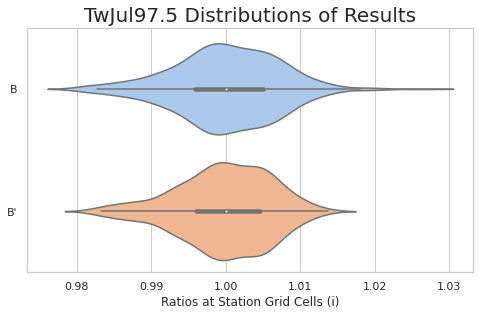

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 285.1665941247201 
UAA_station_mean 282.840625 
Combined 284.00360956236005


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Convert back to degC


# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: degC


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


d: -0.12152235100283448


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)